# Time tracked trajectories - numerical solutions to the HJ equation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as py
import integrate
import potentials
# py.style.use('small_plots.txt') #stylistic choice

import warnings
warnings.filterwarnings("ignore")

Potentials $V = V_0\phi^k$, $H_{\mathrm{initial}} = 2\times10^{-5} M_{pl}$ simulating $H$ trajectories using HJ formalism with initial point in the $\phi > 0, \dot{\phi} < 0$ quadrant, so $\frac{dH}{d\phi} = \sqrt{1.5H^2 - 0.5V}$ (initially at least). We will allow the sign of $\dot{\phi}$ to change in general, in case of which the sign of $\frac{dH}{d\phi}$ would change

We scale $H \rightarrow H \times 10^5 = \tilde{H}$, $V_0 \rightarrow V_0 \times 10^{10} = \tilde{V_0}$ for convenience

PowerPotential(V:φ -> 0.04 * φ^2)
SR Invoked at n = 86791, φ = 18.188245418161454, H = 2.09802667874928, ε = 0.006211900486739601
Final n = 84948
Final N = 61.63167143543612 ,
Final H = 2.5092332725827204 ,
Final ϕ = 17.74227960779905
Solution of desired number of e-folds not available via this method - ε > 1 at n = 91271. Will need to select different parameters to get a solution corresponding to a greater amount of inflation or select `epsilonstop = False'


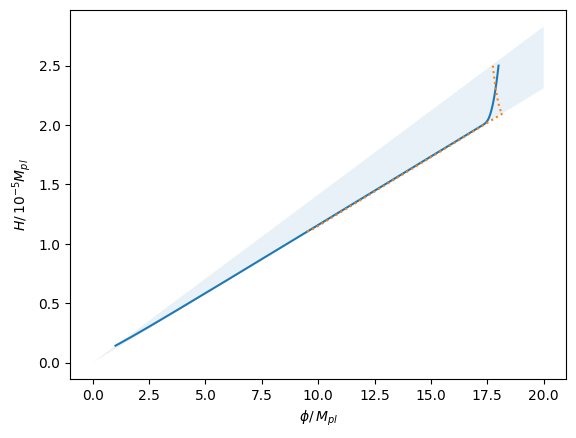

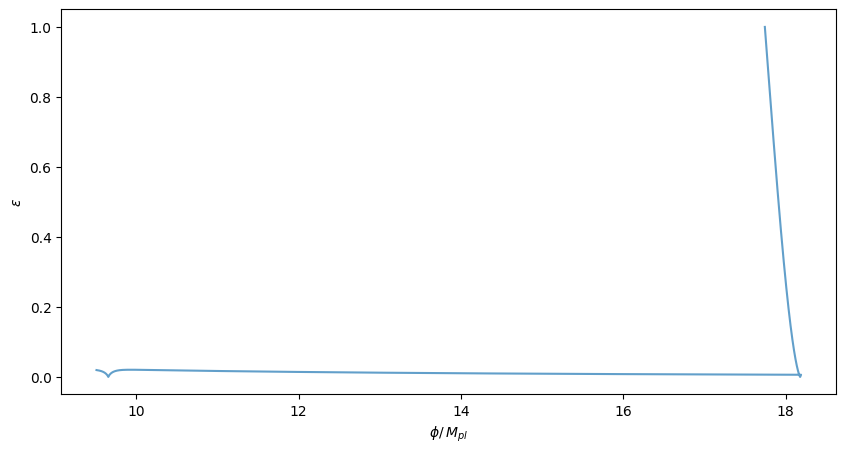

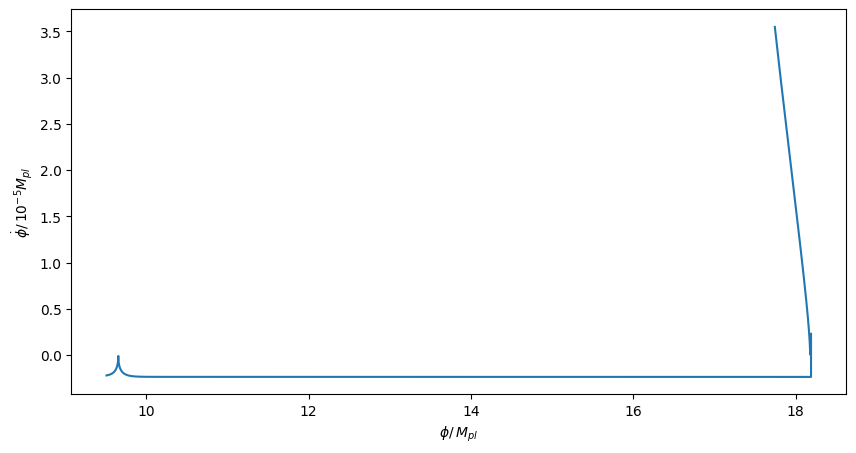

In [22]:
mchoice = 2
V0choice = 0.04

# Add the new time-forward method
V = potentials.PowerPotential(m=mchoice, V0=V0choice)
print(V)
phi_f, H_f, _ = integrate.get_trajectory_decreasing_phi(V, phi_0=18, H_0=2.5, track_N_time=False)
py.plot(phi_f, H_f, label='New Method')
py.xlabel('$\phi/\, M_{pl}$')
py.ylabel('$H/\, 10^{-5} M_{pl}$')

# Add the new time-backward method
δ = 0.004
n = len(phi_f)//2
# # The forward to backward integration offset means a starting point delta is needed
phi_b, H_b, N, ε, n_sgn = integrate.get_trajectory_increasing_phi(V, phi_0=phi_f[n]+δ, H_0=H_f[n], sr_epsilon_limit=0.0005)
py.plot(phi_b, H_b, linestyle='dotted', label='New Backward Method')

# Plot the epsilon feasible region
philine = np.linspace(0, 20, 101)
py.fill_between(philine, [np.sqrt((1/3)*V(p)) for p in philine], [np.sqrt(0.5*V(p)) for p in philine], alpha = 0.1)

# Plot the epsilon trajectory against phi
fig_eps = py.figure(figsize = (10, 5))
py.plot(phi_b, ε, alpha=0.7)
py.xlabel('$\phi/\, M_{pl}$')
py.ylabel('$\epsilon$')


#Next, we convert the solution generated above to the phi - phidot plane. See dissertation 5.6 for details
figalt = py.figure(figsize = (10, 5))

phidot = [-2*integrate.grad_calc(H_b[i], phi_b[i], V) if i<n_sgn else 2*integrate.grad_calc(H_b[i], phi_b[i], V) for i in range(len(phi_b))]
py.plot(phi_b, phidot)
py.xlabel('$\phi/\, M_{pl}$')
py.ylabel('$\dot{\phi}/\,10^{-5} M_{pl}$')



print("Final n =", n, end = '\n')
print("Final N =", N[-1], ',')
print('Final H =', H_b[-1], ',')
print('Final ϕ =', phi_b[-1], end = '\n')
for i, el in enumerate(ε):
    if el > 1 and i > 0:
        print(f"Solution of desired number of e-folds not available via this method - ε > 1 at n = {i}. Will need to select different parameters to get a solution corresponding to a greater amount of inflation or select `epsilonstop = False'")
        break


Users may find the following plot, and information in the disseration associated with this notebook, helpful in choosing appropriate parameters

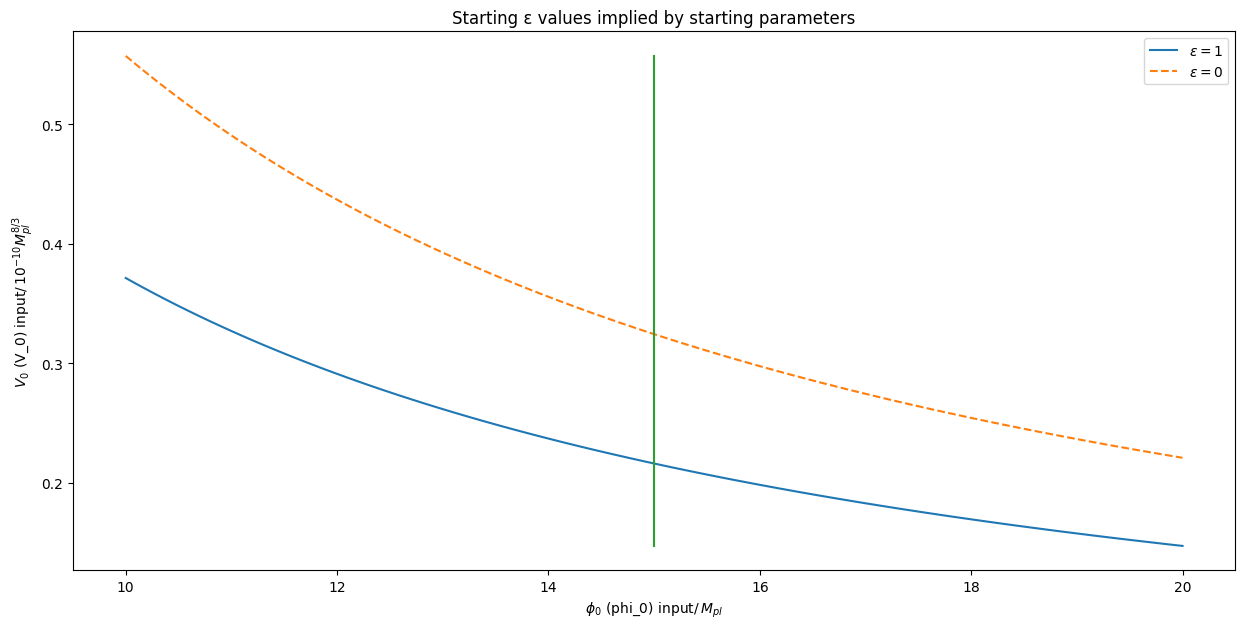

In [24]:
#consider choices of m
h60 = 2
m= 4/3
linechoice = 15

phi60 = np.linspace(10, 20, 101)
Vzero = [(h60**2)*2/(phi**m) for phi in phi60]
Vzero2 = [(h60**2)*3/(phi**m) for phi in phi60]


figgy = py.figure(figsize = (15, 7))
py.plot(phi60, Vzero, label = '$ε = 1$')
py.plot(phi60, Vzero2, '--', label = '$ε = 0$')
py.plot(np.linspace(linechoice, linechoice, 11), np.linspace(Vzero[-1], Vzero2[0], 11))
py.xlabel('$\phi_0$ (phi_0) input$/\, M_{pl}$')
py.ylabel('$V_0$ (V_0) input$/\, 10^{-10}M_{pl}^{8/3}$') #The exponent
py.title('Starting ε values implied by starting parameters')
py.legend()

## $N$ parametrised trajectories of $\phi$, $\dot{\phi}$ and $H$

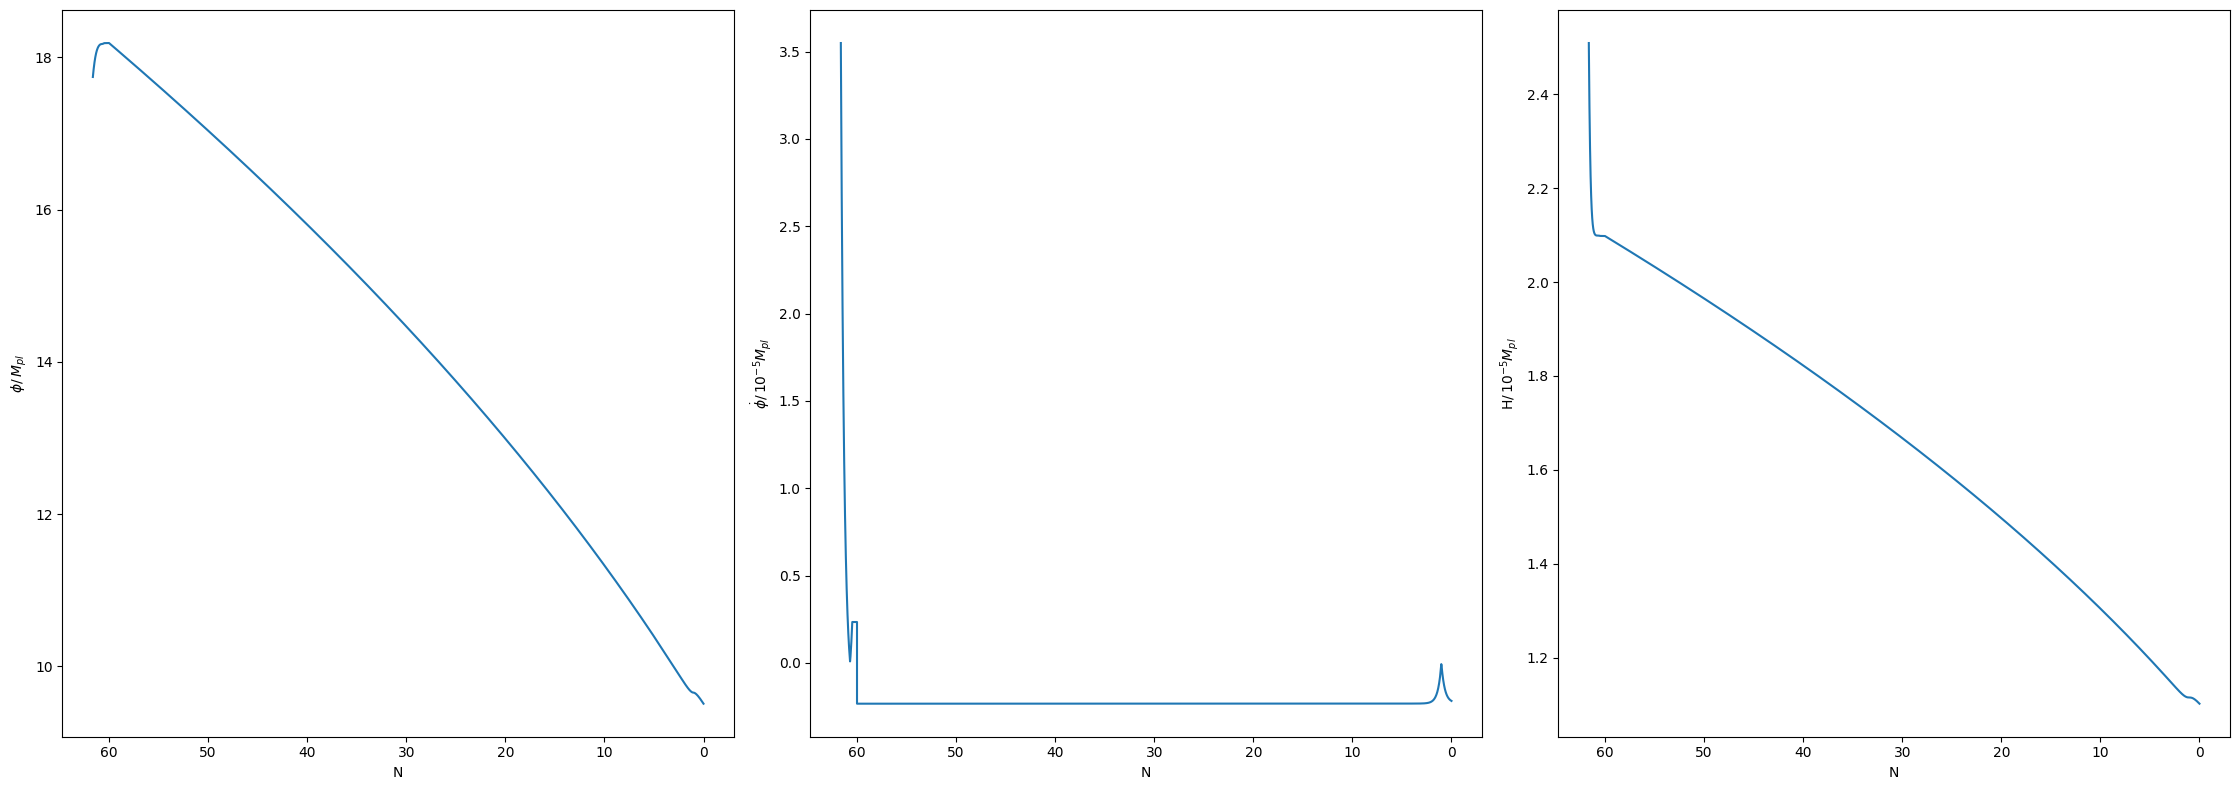

In [27]:

#Now we parametrise by N, plotting 
Ntraj, Nax = py.subplots(1,3, figsize = (22.5, 8))
Nax[0].plot(N, phi_b)
Nax[0].set(xlabel ='N', ylabel = '$\phi/\, M_{pl}$')
Nax[0].invert_xaxis()

Nax[1].plot(N, phidot)
Nax[1].set(xlabel = 'N', ylabel = '$\dot{\phi}/\, 10^{-5} M_{pl}$')
Nax[1].invert_xaxis()

Nax[2].plot(N, H_b)
Nax[2].set(xlabel = 'N', ylabel = 'H/$\, 10^{-5}M_{pl}$')
Nax[2].invert_xaxis()

Ntraj.tight_layout()

n = 20403
N = 2.176000002117528
Full trajectory not available via this method - ε > 1 at n = 20403


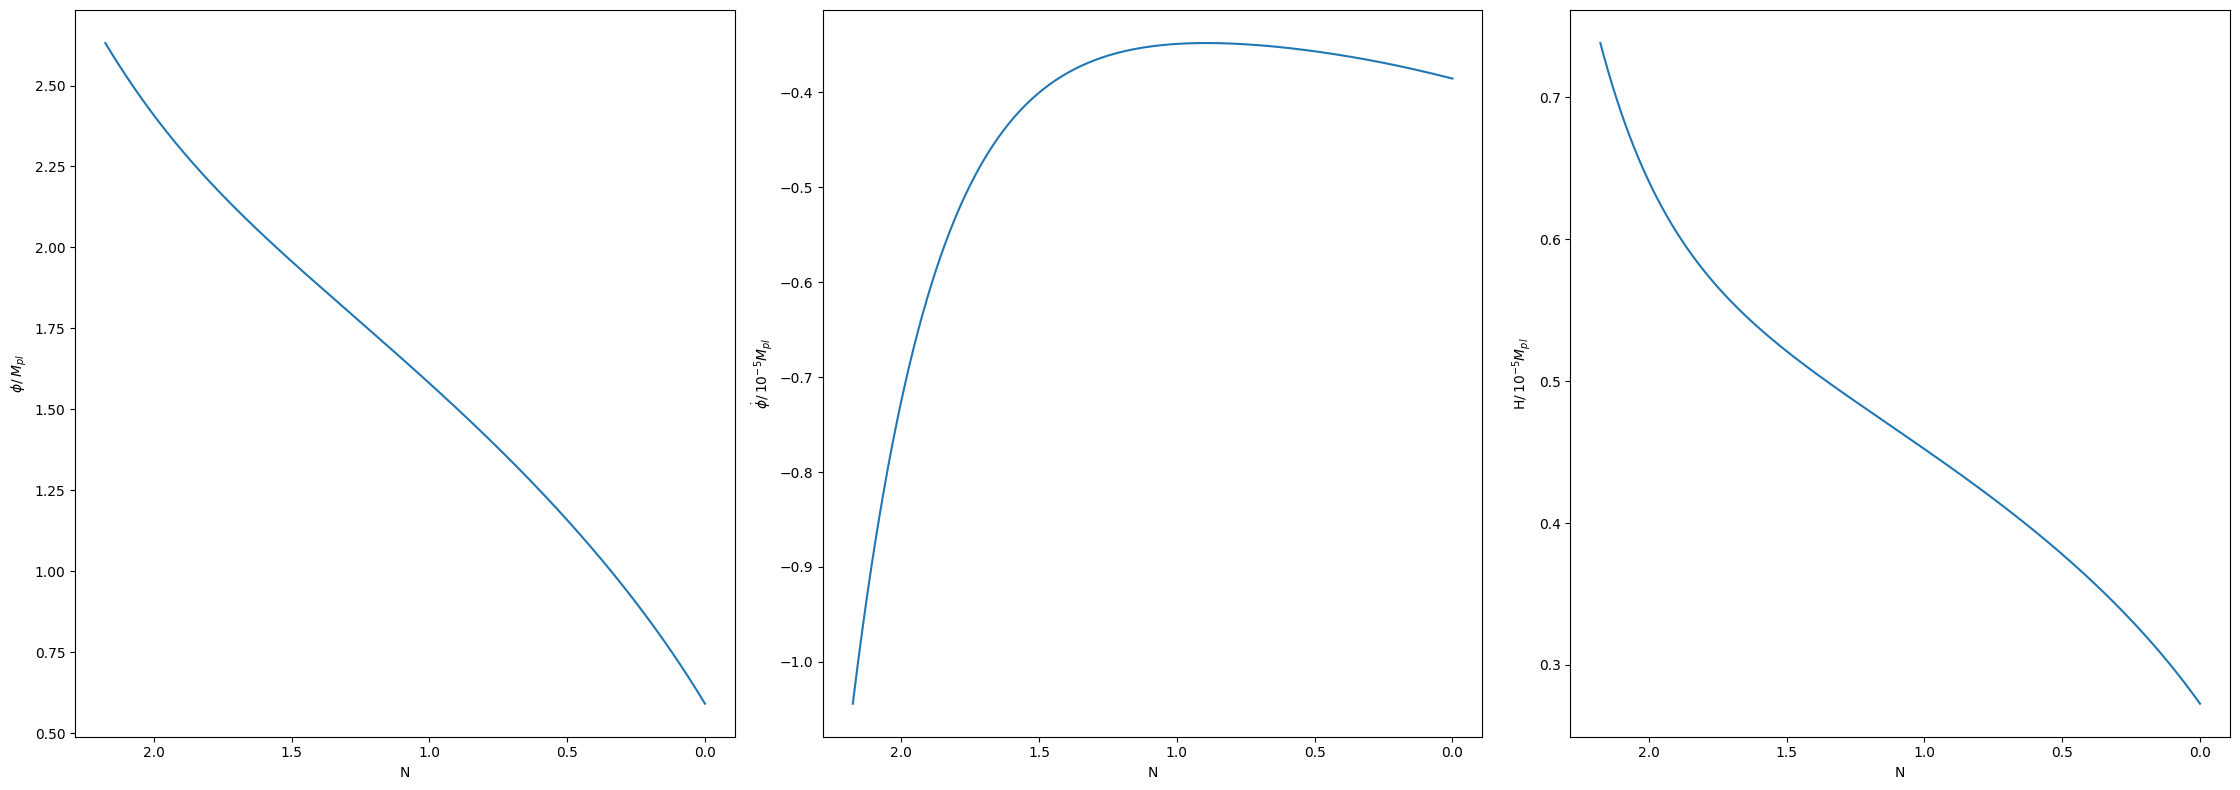

In [30]:
#As before, but new parameters
mchoice = 4/3
V0choice = 0.3

V = potentials.PowerPotential(m=mchoice, V0=V0choice)

phi_f, H_f, _ = integrate.get_trajectory_decreasing_phi(V, phi_0=18, H_0=2.5, track_N_time=False)
phi_b, H_b, N, epsilon, n_sgn = integrate.get_trajectory_increasing_phi(V, phi_0=phi_f[len(phi_f)-2], H_0=H_f[len(H_f)-2], sr_epsilon_limit=0.0005)
phidot = [-2*integrate.grad_calc(H_b[i], phi_b[i], V) if i<n_sgn else 2*integrate.grad_calc(H_b[i], phi_b[i], V) for i in range(len(phi_b))]
n = len(N)-1


print("n =", n, end = '\n')
print("N =", N[-1], end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break

Ntraj, Nax = py.subplots(1,3, figsize = (22.5, 8))
Nax[0].plot(N, phi_b)
Nax[0].set(xlabel ='N', ylabel = '$\phi/\, M_{pl}$')
Nax[0].invert_xaxis()

Nax[1].plot(N, phidot)
Nax[1].set(xlabel = 'N', ylabel = '$\dot{\phi}/\, 10^{-5} M_{pl}$')
Nax[1].invert_xaxis()

Nax[2].plot(N, H_b)
Nax[2].set(xlabel = 'N', ylabel = 'H/$\, 10^{-5}M_{pl}$')
Nax[2].invert_xaxis()

Ntraj.tight_layout()

SR Invoked at n = 94934, φ = 8.87810000002126, H = 2.029452360926977, ε = 0.0026602547167173113
n = 99861
N = 61.79984555604946
Full trajectory not available via this method - ε > 1 at n = 99861


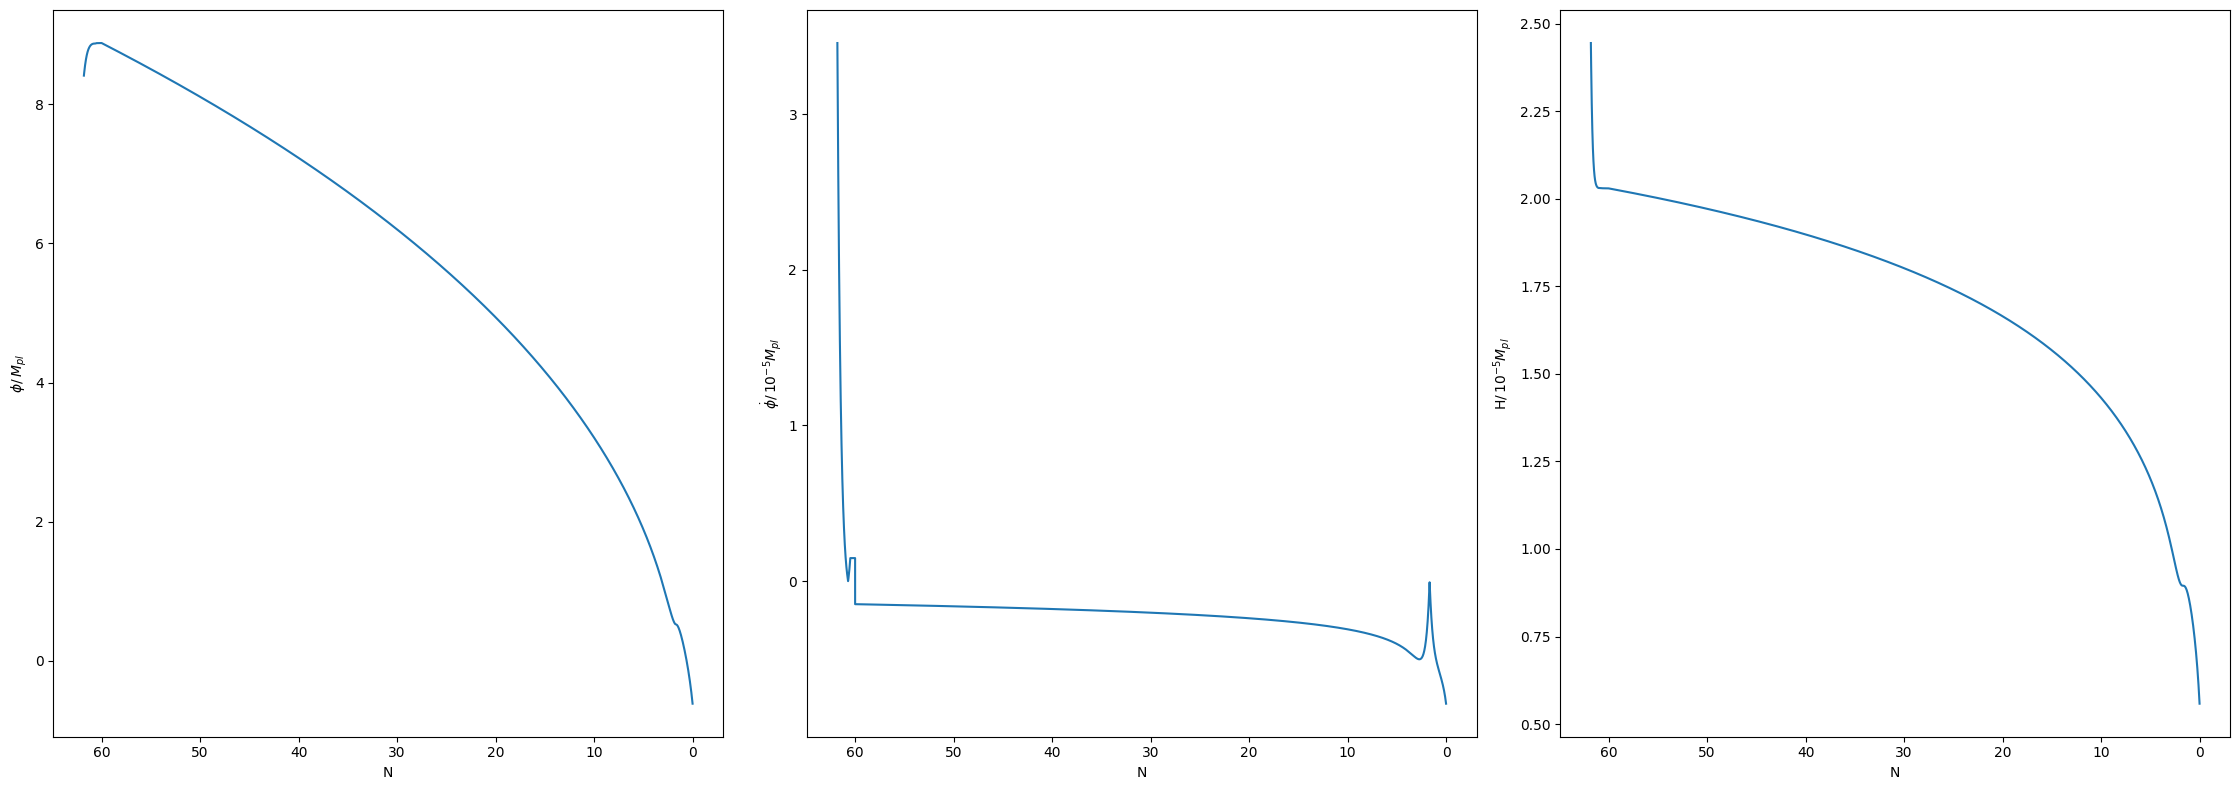

In [39]:
# Let's try a compund potential!

class PolynomialPotential(potentials.Potential):
    def __init__(self, coeffs):
        self.coeffs = coeffs  # coeffs should be a list of coefficients [a0, a1, a2, ...] for a0 + a1*phi + a2*phi^2 + ...

    def value(self, phi):
        return sum(c * phi**i for i, c in enumerate(self.coeffs))
    
    def derivative(self, phi):
        return sum(i * c * phi**(i - 1) for i, c in enumerate(self.coeffs) if i > 0)

V = PolynomialPotential(coeffs=[0.04*40, 0.04*39, -0.04, 1e-4])  # Example: V(φ) = 1.6 + 1.56*φ - 0.04*φ^2 + 0.0001*φ^3

phi_f, H_f, _ = integrate.get_trajectory_decreasing_phi(V, phi_0=18, H_0=2.5, track_N_time=False)
phi_b, H_b, N, epsilon, n_sgn = integrate.get_trajectory_increasing_phi(V, phi_0=phi_f[len(phi_f)-2] + 1e-3, H_0=H_f[len(H_f)-2], sr_epsilon_limit=0.0005)
phidot = [-2*integrate.grad_calc(H_b[i], phi_b[i], V) if i<n_sgn else 2*integrate.grad_calc(H_b[i], phi_b[i], V) for i in range(len(phi_b))]
n = len(N)-1


print("n =", n, end = '\n')
print("N =", N[-1], end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break

Ntraj, Nax = py.subplots(1,3, figsize = (22.5, 8))
Nax[0].plot(N, phi_b)
Nax[0].set(xlabel ='N', ylabel = '$\phi/\, M_{pl}$')
Nax[0].invert_xaxis()

Nax[1].plot(N, phidot)
Nax[1].set(xlabel = 'N', ylabel = '$\dot{\phi}/\, 10^{-5} M_{pl}$')
Nax[1].invert_xaxis()

Nax[2].plot(N, H_b)
Nax[2].set(xlabel = 'N', ylabel = 'H/$\, 10^{-5}M_{pl}$')
Nax[2].invert_xaxis()

Ntraj.tight_layout()